In [50]:
# Import Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from itertools import cycle
from datetime import datetime, timedelta
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display
from scipy import stats
from scipy.stats import median_test
import pymannkendall as mk
import dask

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months
from eofs import *
from ar_funcs import get_ar_days, duration_stats
from kmeans import *
import nclcmaps as ncl

In [20]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [21]:
# choose parameters
reanalysis = 'era5'
ssn = 'djfmam'
ceofid = 'IVT'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

# import configuration file for season dictionary choice
yaml_doc = '../data/plt_config.yml'
config1 = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)

ar_dict = config1[ssn]
start_date = ar_dict['start_date']
end_date = ar_dict['end_date']
print(start_date, end_date)

1979-12-01 9:00 2019-05-31 9:00


In [22]:
# load AR CAT
filepath = out_path + 'AR-types_ALLDAYS.csv'
ar_cat = pd.read_csv(filepath)
ar_cat = ar_cat.rename(columns={'Unnamed: 0': 'time'})
ar_cat = ar_cat.set_index(pd.to_datetime(ar_cat['time']))
# ar_cat.index = ar_cat.index.strftime("%Y-%m-%d")
ar_cat = ar_cat.drop(columns=['time'])
# ar_cat = ar_cat.reset_index()
ar_cat

,AR_CAT
time,
1979-12-01 09:00:00,2
1979-12-02 09:00:00,1
1979-12-03 09:00:00,0
1979-12-04 09:00:00,0
1979-12-05 09:00:00,0
...,...
2019-05-27 09:00:00,0
2019-05-28 09:00:00,0
2019-05-29 09:00:00,1


In [23]:
## Separate the AR Types into multiple columns
# create a new df that breaks up the AR_CAT col so each category has its own column
datesALLdays = ar_cat.index.values
keys = []
for k in range(nk):
    keys.append("AR_CAT{:1d}".format(k+1,))

values = np.zeros((len(datesALLdays)))
dicts = dict(zip(keys, values))

df_cat = pd.DataFrame(dicts, index=datesALLdays)
df_cat['AR_ALL'] = values

for k in range(nk):
    idx = (ar_cat['AR_CAT'] == k+1)
    col = "AR_CAT{:1d}".format(k+1,)
    df_cat.loc[idx, col] = 1
    df_cat.loc[idx, 'AR_ALL'] = 1


df_cat

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL
1979-12-01 09:00:00,0.0,1.0,0.0,1.0
1979-12-02 09:00:00,1.0,0.0,0.0,1.0
1979-12-03 09:00:00,0.0,0.0,0.0,0.0
1979-12-04 09:00:00,0.0,0.0,0.0,0.0
1979-12-05 09:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0
2019-05-28 09:00:00,0.0,0.0,0.0,0.0
2019-05-29 09:00:00,1.0,0.0,0.0,1.0
2019-05-30 09:00:00,0.0,0.0,0.0,0.0


In [24]:
# resample to seasonal frequency
df_ssn = df_cat.resample('QS-DEC').sum()
# select only DJF and MAM
df_ssn = select_months(df_ssn, 12, 5)
df_ssn

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL
1979-12-01,19.0,11.0,8.0,38.0
1980-03-01,4.0,9.0,21.0,34.0
1980-12-01,8.0,15.0,13.0,36.0
1981-03-01,11.0,14.0,22.0,47.0
1981-12-01,14.0,5.0,14.0,33.0
...,...,...,...,...
2017-03-01,6.0,13.0,23.0,42.0
2017-12-01,6.0,5.0,18.0,29.0
2018-03-01,12.0,14.0,15.0,41.0
2018-12-01,12.0,12.0,20.0,44.0


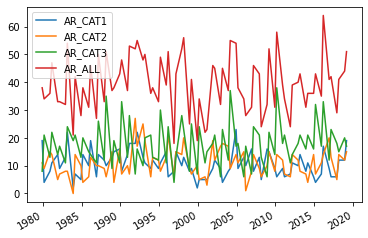

In [25]:
lines = df_ssn.plot.line()

In [26]:
tmp = df_ssn['AR_CAT1'].values

In [27]:
trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(df_ssn['AR_CAT1'].values)
trend

'no trend'

In [28]:
data_lst = ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'AR_ALL']
for i, data in enumerate(data_lst):
    print(mk.original_test(df_ssn[data].values))

Mann_Kendall_Test(trend='no trend', h=False, p=0.1588212688706907, z=-1.409047007200642, Tau=-0.10727848101265823, s=-339.0, var_s=57541.666666666664, slope=-0.03252247488101534, intercept=11.284637757800105)
Mann_Kendall_Test(trend='no trend', h=False, p=0.5183001287196802, z=0.6459679240054902, Tau=0.049367088607594936, s=156.0, var_s=57576.0, slope=0.0, intercept=10.5)
Mann_Kendall_Test(trend='no trend', h=False, p=0.4437738123749595, z=0.7658361316306797, Tau=0.058544303797468354, s=185.0, var_s=57725.0, slope=0.02532051282051282, intercept=15.999839743589744)
Mann_Kendall_Test(trend='no trend', h=False, p=0.7020424964925711, z=0.38256476936707917, Tau=0.029430379746835444, s=93.0, var_s=57831.666666666664, slope=0.017879948914431672, intercept=37.79374201787995)


In [29]:
df_yr = df_ssn.resample('1Y').sum()
for i, data in enumerate(data_lst):
    print(mk.original_test(df_yr[data].values))

Mann_Kendall_Test(trend='no trend', h=False, p=0.1906467034197048, z=-1.3086683906166645, Tau=-0.14268292682926828, s=-117.0, var_s=7857.0, slope=-0.09449404761904762, intercept=22.889880952380953)
Mann_Kendall_Test(trend='no trend', h=False, p=0.5358254185658282, z=0.6191380502916255, Tau=0.06829268292682927, s=56.0, var_s=7891.333333333333, slope=0.0625, intercept=20.75)
Mann_Kendall_Test(trend='no trend', h=False, p=0.3984935043101916, z=0.8443148244652351, Tau=0.09268292682926829, s=76.0, var_s=7890.666666666667, slope=0.09090909090909091, intercept=33.18181818181818)
Mann_Kendall_Test(trend='no trend', h=False, p=0.7444343648126583, z=0.32598677008958427, Tau=0.036585365853658534, s=30.0, var_s=7914.0, slope=0.06559139784946236, intercept=75.68817204301075)


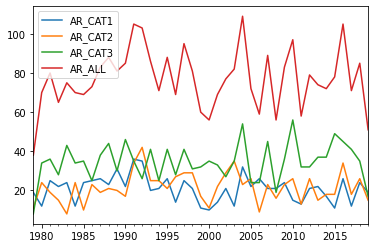

In [30]:
lines = df_yr.plot.line()

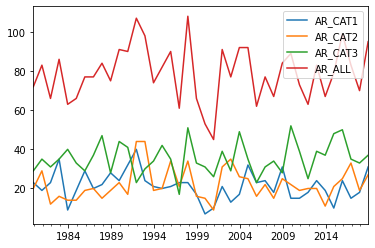

In [31]:
# resample to seasonal frequency
df_test = df_cat.resample('6MS').sum()
df_test = select_months(df_test, 12, 5)
lines = df_test.plot.line()

In [32]:
for i, data in enumerate(data_lst):
    print(mk.original_test(df_test[data].values))

Mann_Kendall_Test(trend='no trend', h=False, p=0.20663848706021004, z=-1.2628628106270983, Tau=-0.13974358974358975, s=-109.0, var_s=7313.666666666667, slope=-0.125, intercept=23.4375)
Mann_Kendall_Test(trend='no trend', h=False, p=0.2377160972668082, z=1.180714656098316, Tau=0.13076923076923078, s=102.0, var_s=7317.333333333333, slope=0.10263157894736842, intercept=17.998684210526317)
Mann_Kendall_Test(trend='no trend', h=False, p=0.3938103208123249, z=0.8527277094885621, Tau=0.09487179487179487, s=74.0, var_s=7328.666666666667, slope=0.10263157894736842, intercept=32.998684210526314)
Mann_Kendall_Test(trend='no trend', h=False, p=0.5834048224838704, z=0.5484181415848901, Tau=0.06153846153846154, s=48.0, var_s=7344.666666666667, slope=0.10101010101010101, intercept=76.03030303030303)


In [48]:
rename_dict = {'AR_CAT1': 'Type 1: Western HMA AR', 'AR_CAT2': 'Type 2: Northwestern HMA AR', 'AR_CAT3': 'Type 3: Eastern HMA AR'}
df_tmp = df_cat.drop(columns=['AR_ALL'])
df_tmp = df_tmp.rename(columns = rename_dict, inplace = False)
df_tmp = df_tmp.groupby(df_cat.index.month).sum()
df_tmp.loc[:,"Month"] = df_tmp.index
results = pd.melt(df_tmp, id_vars=['Month'], var_name='subtype', value_name='frequency')
results

,Month,subtype,frequency
0,1,Type 1: Western HMA AR,158.0
1,2,Type 1: Western HMA AR,157.0
2,3,Type 1: Western HMA AR,235.0
3,4,Type 1: Western HMA AR,143.0
4,5,Type 1: Western HMA AR,60.0
5,12,Type 1: Western HMA AR,104.0
6,1,Type 2: Northwestern HMA AR,139.0
7,2,Type 2: Northwestern HMA AR,171.0
8,3,Type 2: Northwestern HMA AR,228.0
9,4,Type 2: Northwestern HMA AR,126.0


In [34]:
# read precip and ivt df
fname = path_to_out + 'DJFMAM_prec_ivt_ar_types.csv'
df = pd.read_csv(fname)
df


,Unnamed: 0,trackID,ar_cat,start_date,end_date,duration,ivty,ivtx,ivt,hlat,hlon,pamir,karakoram,eastern,prec
0,0,2861.0,1,1979-12-02 00:00:00,1979-12-02 18:00:00,18.0,84.715817,156.934744,178.340359,54.000000,88.950000,10.849489,2.692042,6.117218,10.849489
1,1,2871.0,1,1979-12-09 06:00:00,1979-12-09 18:00:00,12.0,140.456836,255.515681,291.575695,58.855263,137.842105,0.000000,0.000000,0.000000,0.000000
2,2,2975.0,1,1979-12-16 12:00:00,1979-12-17 00:00:00,12.0,123.568145,129.182257,178.765606,40.000000,64.000000,3.015333,0.938811,4.503502,3.015333
3,3,2988.0,1,1979-12-21 00:00:00,1979-12-22 12:00:00,36.0,118.158087,138.478370,182.037338,33.600000,56.800000,10.341680,4.771686,3.265799,10.341680
4,4,3026.0,1,1979-12-24 06:00:00,1979-12-24 12:00:00,6.0,95.302288,105.452260,142.136221,28.500000,69.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2684,2684,128613.0,3,2019-05-06 06:00:00,2019-05-06 12:00:00,6.0,152.255674,36.972662,156.680465,40.500000,102.000000,0.000000,0.000000,0.000000,0.000000
2685,2685,128655.0,3,2019-05-12 06:00:00,2019-05-12 12:00:00,6.0,92.532689,210.106101,229.579773,30.000000,100.500000,0.000000,0.000000,0.000000,0.000000
2686,2686,128755.0,3,2019-05-24 00:00:00,2019-05-24 06:00:00,6.0,59.469964,404.299149,408.649579,24.000000,100.500000,6.547526,8.051527,11.751484,11.751484
2687,2687,128763.0,3,2019-05-25 00:00:00,2019-05-25 06:00:00,6.0,269.018570,280.446504,388.614504,44.307692,140.653846,5.966172,1.231151,13.648691,13.648691


<AxesSubplot:xlabel='ar_cat', ylabel='prec'>

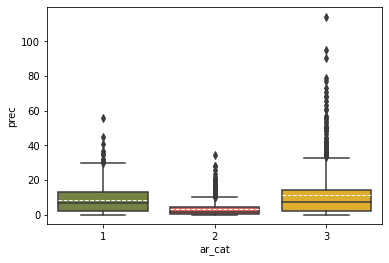

In [39]:
colors = np.array(([122/256, 141/256, 57/256, 1], # green
                   [239/256, 86/256, 69/256, 1],  # coral
                   [254/256, 188/256, 17/256, 1]))  # gold

sns.boxplot(x="ar_cat", y="prec", data=df, hue=None, palette=colors,
                    meanline=True, showmeans=True, meanprops={'c':'white', 'lw':1})

In [51]:
## Mood's median test
g1 = df.prec.loc[(df.ar_cat == 1)].values
g2 = df.prec.loc[(df.ar_cat == 2)].values
g3 = df.prec.loc[(df.ar_cat == 3)].values
stat, p, med, tbl = median_test(g1, g2, g3)
print(p)

2.8254878984565278e-08


<AxesSubplot:xlabel='ar_cat', ylabel='ivt'>

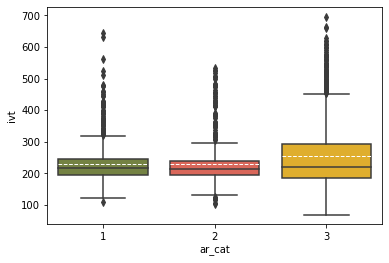

In [37]:
colors = np.array(([122/256, 141/256, 57/256, 1], # green
                   [239/256, 86/256, 69/256, 1],  # coral
                   [254/256, 188/256, 17/256, 1]))  # gold

sns.boxplot(x="ar_cat", y="ivt", data=df, hue=None, palette=colors,
                    meanline=True, showmeans=True, meanprops={'c':'white', 'lw':1})

In [52]:
## Mood's median test
g1 = df.ivt.loc[(df.ar_cat == 1)].values
g2 = df.ivt.loc[(df.ar_cat == 2)].values
g3 = df.ivt.loc[(df.ar_cat == 3)].values
stat, p, med, tbl = median_test(g1, g2, g3)
print(p)

0.009720367002666732


In [64]:
for i in range(1,4):
    tmp = df.loc[(df.ar_cat == i)]
    print(tmp.ivt.median())
    print(tmp.ivt.describe())

216.03206576280883
count    720.000000
mean     228.293073
std       65.260933
min      108.422799
25%      193.610305
50%      216.032066
75%      244.086985
max      642.803396
Name: ivt, dtype: float64
214.25827999659293
count    711.000000
mean     228.530078
std       67.147859
min      103.982154
25%      195.229545
50%      214.258280
75%      239.556585
max      534.606489
Name: ivt, dtype: float64
220.8556355722775
count    1258.000000
mean      254.308006
std       102.867991
min        69.753318
25%       186.523758
50%       220.855636
75%       293.506703
max       695.366515
Name: ivt, dtype: float64


In [63]:
def get_num_outliers(column):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    return sum((column<q1) | (column>q3))

tmp = df.groupby('ar_cat').agg([get_num_outliers])
tmp['ivt']

,get_num_outliers
ar_cat,
1,360.0
2,356.0
3,630.0


In [65]:
for i in range(1,4):
    tmp = df.loc[(df.ar_cat == i)]
    print(tmp.prec.median())
    print(tmp.prec.describe())

2.7027377958997105
count    720.000000
mean       6.153239
std        7.850294
min        0.000000
25%        0.000000
50%        2.702738
75%       10.052090
max       55.571241
Name: prec, dtype: float64
0.6541827543753792
count    711.000000
mean       2.456961
std        4.239720
min        0.000000
25%        0.000000
50%        0.654183
75%        3.155085
max       34.414143
Name: prec, dtype: float64
0.9495681249096926
count    1258.000000
mean        6.776680
std        12.129454
min         0.000000
25%         0.000000
50%         0.949568
75%         9.282566
max       114.194927
Name: prec, dtype: float64


In [66]:
tmp = df.groupby('ar_cat').agg([get_num_outliers])
tmp['prec']

,get_num_outliers
ar_cat,
1,180.0
2,178.0
3,315.0


/home/nash/DATA/repositories/AR_types/figs/IVT/djfmam/neof2/k3/ARTYPE_freq_barplot.png


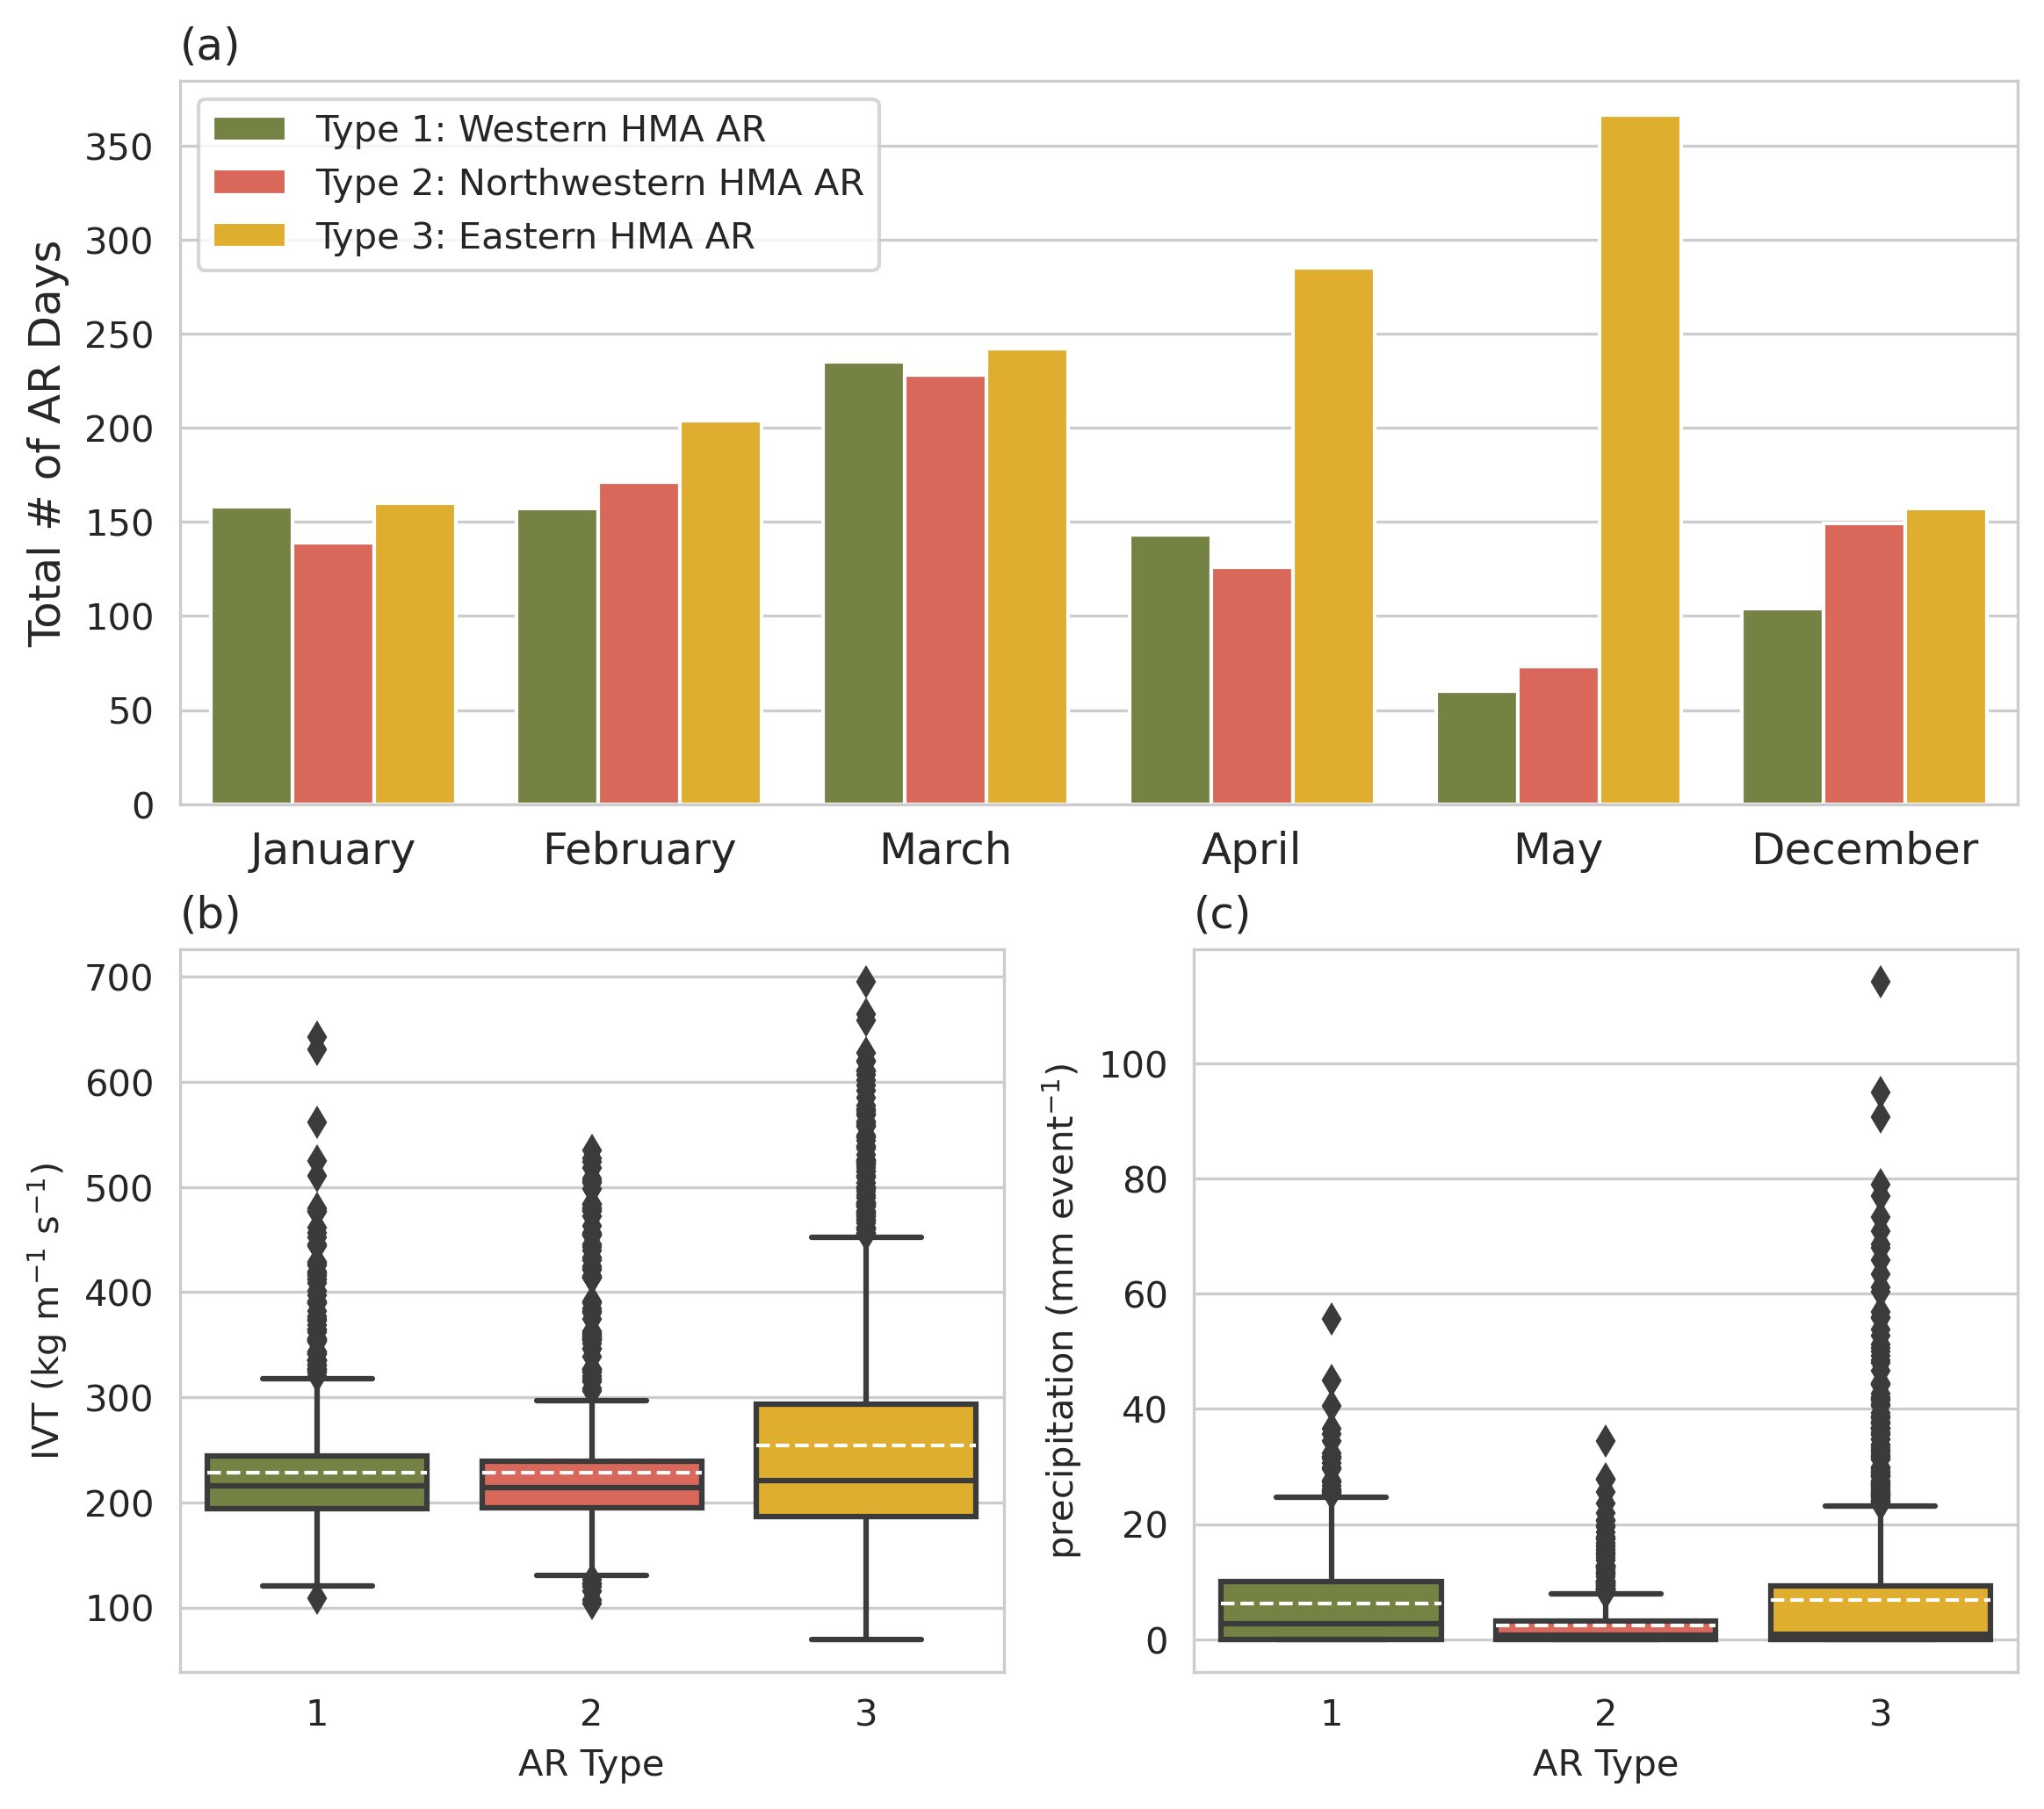

<Figure size 2700x2400 with 0 Axes>

In [49]:
fname = fig_path + 'ARTYPE_freq_barplot' 
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((9.0,8.0))
fig.dpi = 300
nplots=1

# Set custom color palette
# colors = ['#95a462', '#ef6758', '#fcbd23']

colors = np.array(([122/256, 141/256, 57/256, 1], # green
                   [239/256, 86/256, 69/256, 1],  # coral
                   [254/256, 188/256, 17/256, 1]))  # gold

sns.set_palette(sns.color_palette(colors))
columns=['January', 'February', 'March', 'April', 'May', 'December']
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

gs = fig.add_gridspec(nrows=2, ncols=4, wspace=0.6)

## Barplot of AR Types ##
ax1 = fig.add_subplot(gs[0,:])
g = sns.barplot(x='Month', y='frequency', hue='subtype', data=results)
ax1.set_ylabel('Total # of AR Days', fontsize=12)
ax1.set_xlabel('')
ax1.set_xticklabels(columns, fontsize=12)
ax1.legend(loc='upper left')
ax1.set_title('(a)', loc='left')

## IVT Boxplot AR Types ##
ax2 = fig.add_subplot(gs[1,:2])
g = sns.boxplot(x="ar_cat", y="ivt", data=df, hue=None, palette=colors,
                    meanline=True, showmeans=True, meanprops={'c':'white', 'lw':1})
ax2.set_ylabel('IVT (kg m$^{-1}$ s$^{-1}$)')
ax2.set_xlabel('AR Type')
ax2.set_title('(b)', loc='left')

## Prec Boxplot AR Types ##
ax3 = fig.add_subplot(gs[1,2:])
g = sns.boxplot(x="ar_cat", y="prec", data=df, hue=None, palette=colors,
                    meanline=True, showmeans=True, meanprops={'c':'white', 'lw':1})
ax3.set_ylabel('precipitation (mm event$^{-1}$)')
ax3.set_xlabel('AR Type')
ax3.set_title('(c)', loc='left')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))